In [49]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
leaf_dir = "./data/"

In [51]:
scans = glob.glob(leaf_dir + "*.tiff")

In [61]:
# 1x1mm^2 pixel value function
def scan_measure(scan_file):
    # load image
    img = cv2.imread(scan_file)
    img_cut = img[2500:, 1500:]
    # find minimum pixel value of rgb channels
    img_min = np.min(img_cut, axis=2)
    img_binary = img_min < 150
    # find contours (objects)
    contours, _ = cv2.findContours(img_binary.astype('uint8'), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
    # loop through contours and save only valid contours
    pixel_area_list = []
    for i in contours:      
        area = cv2.contourArea(i)  # area in pixels/1cm^2
        if area > 10000:
            # converting pixels cm^2 to pixels mm^2
            pixels_per_mm2 = area / 10**2
            pixel_area_list.append(pixels_per_mm2)
        else:
            continue   
    if len(pixel_area_list) == 1:
        return pixel_area_list[0]
    else:
        print("multiple large contours detected")
            

In [62]:
def find_leaf_area(
    scan_file: str,
    pixel_per_mm2: float,
    upper_pixel_value_threshold: int = 150,
    min_area: float = 1000,
) -> float:
    # set up plots
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(11, 5)
    fig.patch.set_facecolor('white')
    # load image
    img = cv2.imread(scan_file)
    # find minimum pixel value of rgb channels
    img_min = np.min(img, axis=2)
    # threshold image
    img_binary = img_min < upper_pixel_value_threshold
    # find contours (objects)
    contours, _ = cv2.findContours(image=img_binary.astype('uint8'), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    # loop through contours and save only valid contours
    valid_contour_list = []
    contour_area_list = []
    for single_contour in contours:
        area = cv2.contourArea(single_contour)
        x, y, w, h = cv2.boundingRect(single_contour)
        if x > 1700 and y > 2700:
            # ignore contours in the bottom right
            continue
        elif area < min_area:
            # ignore small contours
            continue
        elif w > 100 * h or h > 100 * w:
            # ignore contours with height much greater than width or width much greater than height
            continue
        elif x < 100 or y < 100:
            # ignore contours stuck to left and top
            continue
        elif x > img.shape[1] - 100 or y > img.shape[0] - 100:
            # ignore contours stuck to right and bottom
            continue
        # convert area to mm^2
        area_mm2 = area * pixel_per_mm2 **-1
        valid_contour_list.append(single_contour)
        contour_area_list.append(area_mm2)
    # show thumbnails
    axs[0].set_title(scan_file)
    ax1 = axs[0].imshow(img)
    # contours are exaggerated for visualization purposes
    axs[1].set_title(
        'Detected Leaves\n'
        f'Area of each detected leaf (mm^2): {contour_area_list}\n'
        f'Area of detected leaves combined (mm^2): {sum(contour_area_list)}\n'
      
    ) 
    ax2 = axs[1].imshow(
        cv2.drawContours(image=img, contours=valid_contour_list, contourIdx=-1, color=(0, 255, 0), thickness=100)
    )
    #print(f'Area of each detected leaf: {contour_area_list}')
    #print(f'Area of detected leaves combined: {sum(contour_area_list)}')
    return sum(contour_area_list)

Name             |  Total Leaf Area (mm^2)
./data/AO1.1.tiff 	 250.98775574071902
./data/AO1.2.tiff 	 237.27576298827364


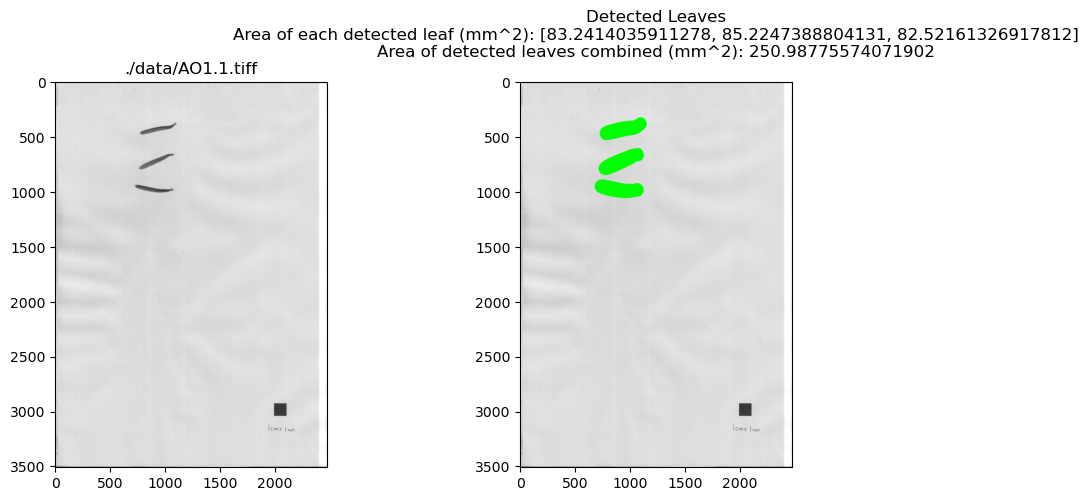

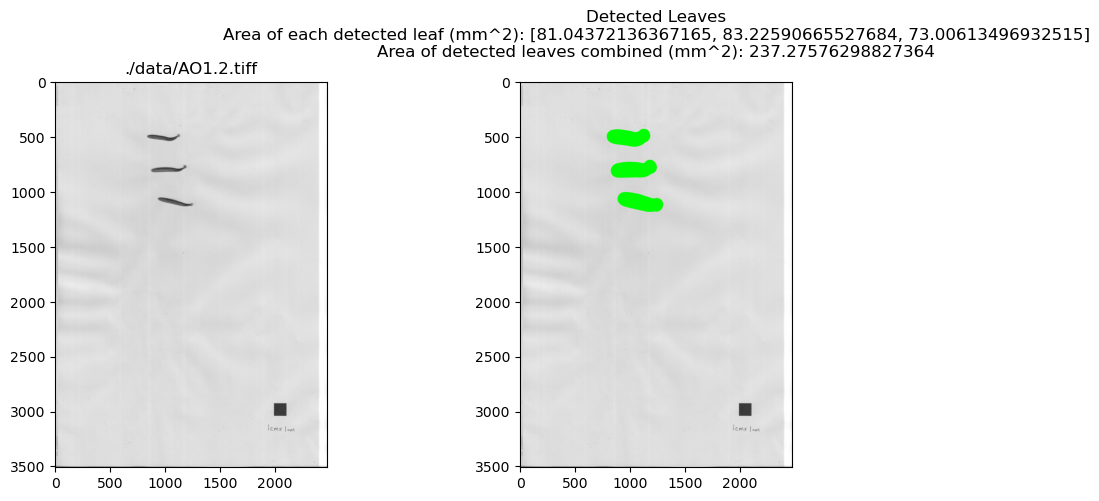

In [63]:
# Loop to find 1x1cm cube length in pixels
print('Name           ', ' | ', 'Total Leaf Area (mm^2)')
for i in scans:
    pixel_per_mm2 = scan_measure(i)
    total_leaf_area_mm2 = find_leaf_area(i, pixel_per_mm2)
    print(i, '\t', total_leaf_area_mm2)
